# Étape 1 : Importation des librairies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display, HTML

sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Étape 2 : Chargement des données

In [12]:
train = pd.read_csv('assets/files/train.csv')
test = pd.read_csv('assets/files/test.csv')

print(f"Dimension de train : {train.shape}")
print(f"Dimension de test  : {test.shape}")

Forme de train : (1600, 6)
Forme de test  : (400, 5)


# Étape 3 : Aperçu des données (head, info, describe)

In [22]:

display(
    HTML(
        pd.concat(
            {
                'Train': train.head(),
                '|': pd.DataFrame(['|'] * len(train.head())),
                '|': pd.DataFrame(['|'] * len(train.head())),
                '|': pd.DataFrame(['|'] * len(train.head())),
                'Test': test.head()
            },
            axis=1
        ).to_html(index=False)
    )
)


In [23]:
print("Infos train :")
train.info()

print("Stats descriptives train :")
display(train.describe().T)

Infos train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  1600 non-null   float64
 1   feature_2  1600 non-null   float64
 2   feature_3  1600 non-null   float64
 3   feature_4  1600 non-null   float64
 4   feature_5  1600 non-null   float64
 5   target     1600 non-null   float64
dtypes: float64(6)
memory usage: 75.1 KB
Stats descriptives train :


,count,mean,std,min,25%,50%,75%,max
feature_1,1600.0,0.004114,0.997338,-3.380125,-0.647165,-0.000360,0.682118,3.287205
feature_2,1600.0,-0.027604,1.021776,-3.314844,-0.705030,-0.043769,0.645442,3.438895
feature_3,1600.0,-0.044459,1.011768,-3.153118,-0.706385,-0.041272,0.639130,3.216176
feature_4,1600.0,-0.042408,1.017189,-3.250169,-0.709504,-0.029756,0.646290,2.985410
feature_5,1600.0,0.012005,0.978654,-2.851707,-0.615880,-0.013527,0.650089,3.321770
target,1600.0,0.318835,110.741562,-379.829794,-71.897040,-0.610665,71.226603,337.643014


### Interpretation : Les variables explicatives (feature_1 à feature_5)
- Les 5 features semblent standardisées (moyenne ≈ 0, écart-type ≈ 1).
Cela suggère un prétraitement déjà effectué sans doute une normalisation de type StandardScaler.

- Les valeurs minimales et maximales sont proches de ±3 : typique de données centrées réduites issues d’une loi normale.

- Aucune variable ne présente de biais évident (moyenne ≈ 0, médiane ≈ 0).

Ces variables sont bien équilibrées et prêtes à être utilisées pour l’entraînement du modèle.</br></br>

### Interpretation : La variable cible (target)

- Moyenne : ~0.32 : proche de zéro, donc centrée également.

- Écart-type énorme : 110.7, bien supérieur à celui des features (~1). Cela indique :

    - Une forte variabilité des valeurs cibles ;
    
    - La présence possible de valeurs extrêmes (outliers) ou d’une échelle différente par rapport aux entrées.

- Les bornes min/max sont très asymétriques :

    - Min = -379.83
    - Max = 337.64
    C'est une distribution sans doute large et potentiellement non normale (queue épaisse).</br></br>

# Étape 4 : Analyse exploratoire (EDA)


- ### Vérification des valeurs manquantes

In [7]:
print("Valeurs manquantes dans train :", train.isnull().sum().sum())
print("Valeurs manquantes dans test :", test.isnull().sum().sum())

Valeurs manquantes dans train : 0
Valeurs manquantes dans test : 0



- ### Visualisation de la matrice de corrélation

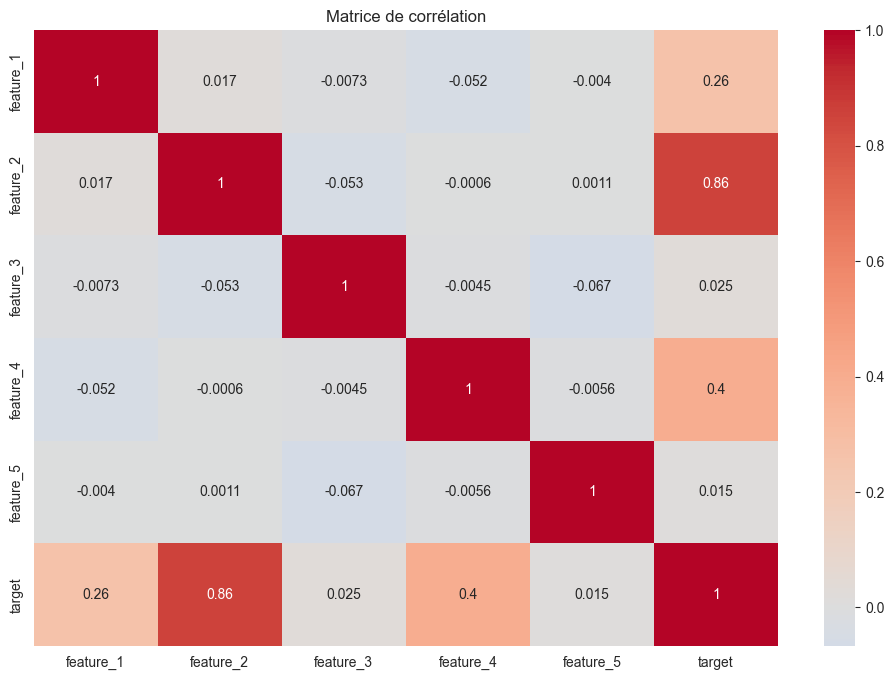

In [8]:
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation")
plt.show()

### Interpretation : 

Les cinq variables explicatives (feature_1 à feature_5) présentent très peu de corrélation entre elles, avec des coefficients proches de zéro pour la plupart des paires. Cela indique que ces variables sont essentiellement indépendantes, ce qui est positif pour la plupart des modèles de régression, car il y a peu de multicolinéarité.

En revanche, la variable cible (target) montre des corrélations variées avec les features :

feature_2 et target ont une corrélation élevée (≈0.86), ce qui suggère que feature_2 est un prédicteur très influent pour expliquer la cible.

feature_4 et target présentent une corrélation modérée (≈0.40), indiquant un lien plus faible mais significatif.

Les autres features (feature_1, feature_3, feature_5) sont faiblement corrélées avec la cible, donc elles auront probablement moins d’impact direct dans un modèle linéaire.

En résumé, le dataset présente des features globalement indépendantes entre elles, avec une ou deux features particulièrement pertinentes pour prédire la cible, ce qui facilitera la modélisation et la sélection de variables.

## Pairplot (relations et distributions)

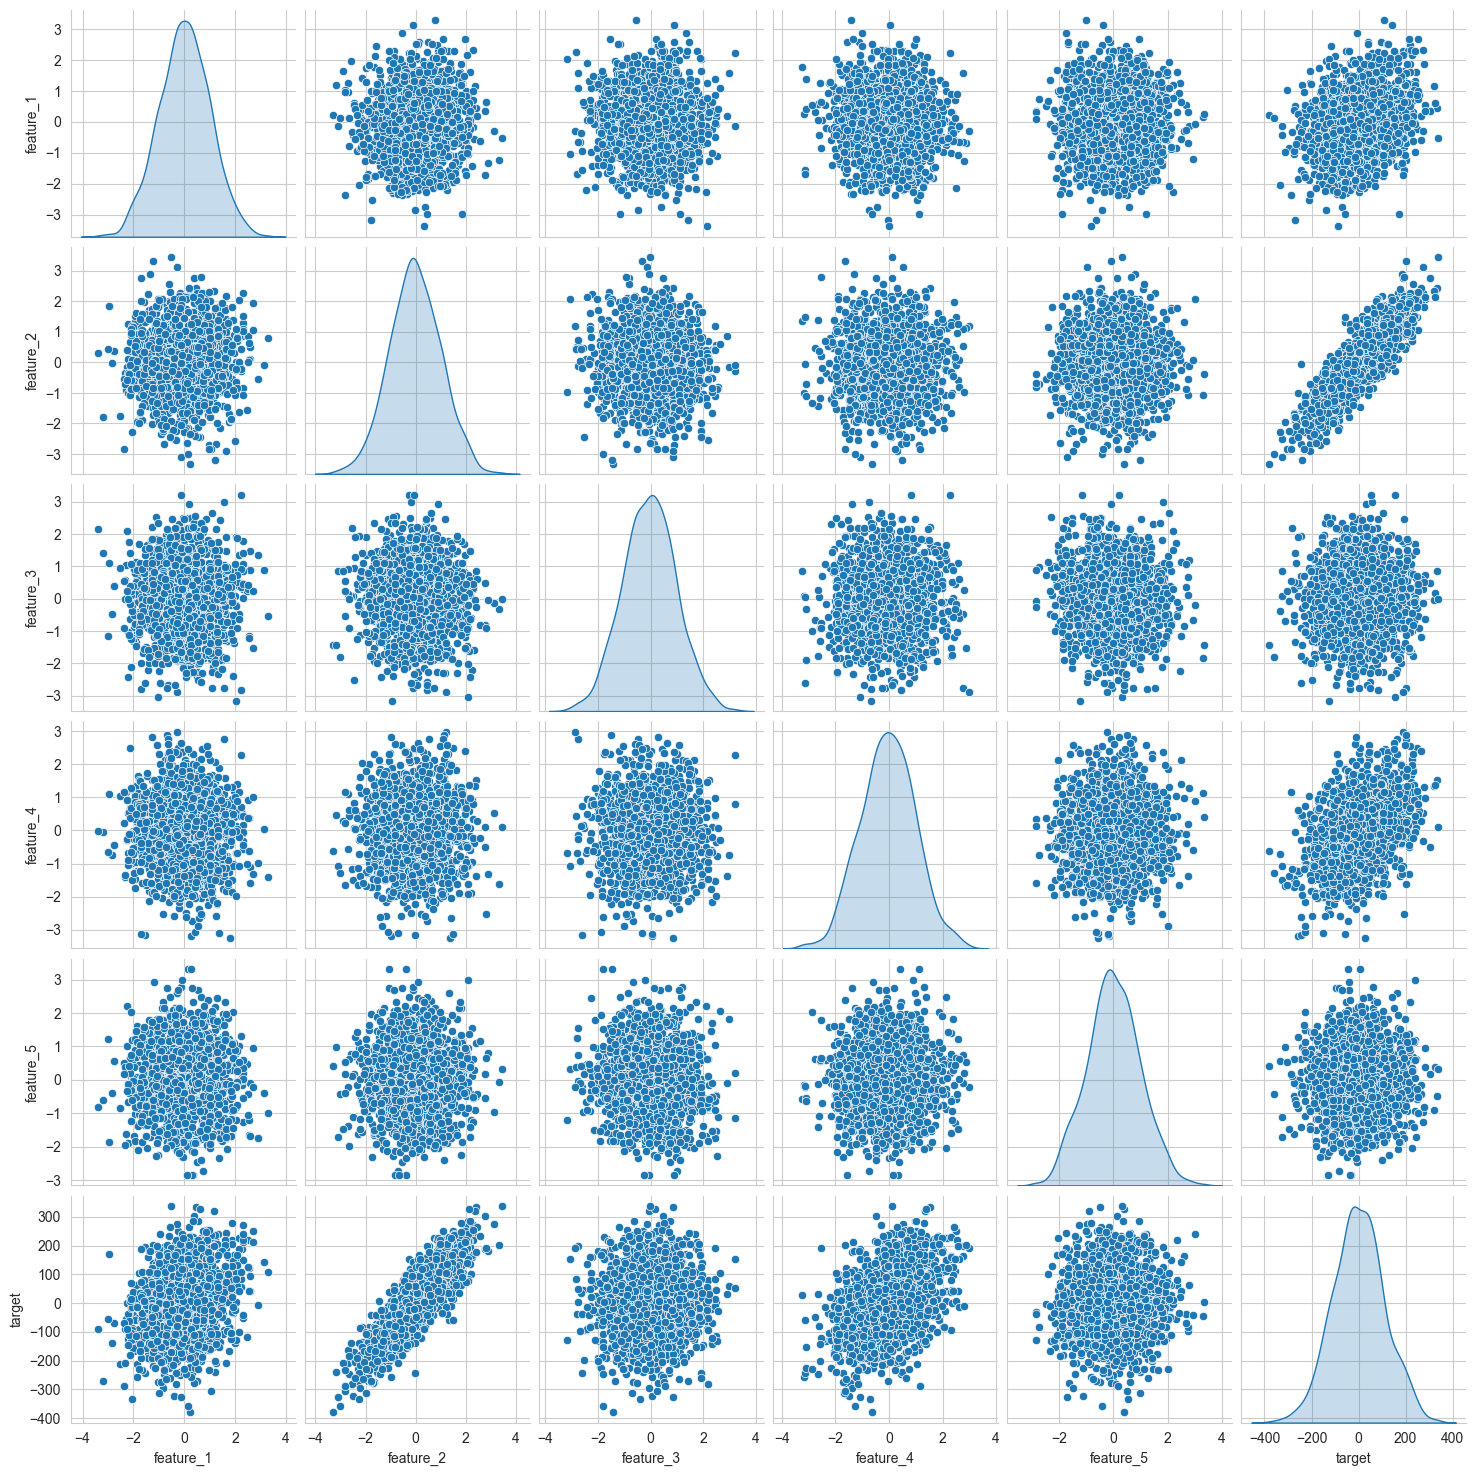

In [26]:
sns.pairplot(train, diag_kind='kde')
plt.show()

# Étape 5 : Préparation des données pour la modélisation

In [28]:
X = train.drop('target', axis=1)
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f" X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f" X_val : {X_val.shape}, y_val : {y_val.shape}")

 X_train : (1280, 5), y_train : (1280,)
 X_val : (320, 5), y_val : (320,)


# Étape 6 : Entraînement du modèle – Régression Linéaire (baseline)

## Régression linéaire

La **régression linéaire** est un modèle statistique qui cherche à prédire une variable cible `y` à partir de variables explicatives `X` en supposant une relation **linéaire** :

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
$$

- **β₀** : intercept (valeur de `y` lorsque toutes les `x` = 0)  
- **βᵢ** : coefficients représentant l’influence de chaque feature  
- **ε** : terme d’erreur (différence entre prédiction et valeur réelle)

L’algorithme apprend les coefficients **βᵢ** pour **minimiser l’erreur**, souvent l’erreur quadratique moyenne (MSE), entre les prédictions et les valeurs réelles.</br></br>


In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)

print("Régression Linéaire - Performances sur validation :")
print(f"MSE : {mean_squared_error(y_val, y_pred_lr):.2f}")
print(f"R² : {r2_score(y_val, y_pred_lr):.4f}")

# Validation croisée sur tout le train
cv_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print(f"R² moyen CV : {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")

Régression Linéaire - Performances sur validation :
MSE : 416.28
R² : 0.9645
R² moyen CV : 0.9656 (± 0.0026)


</br>Le MSE représente l’erreur quadratique moyenne entre les prédictions et les vraies valeurs de la cible.

- Plus il est faible, plus les prédictions sont proches des valeurs réelles.

- Ici, un MSE de 416.28 indique que, en moyenne, la différence quadratique entre la prédiction et la vraie valeur est de 416.28.

- Pour juger si c’est “bon” ou “mauvais”, il faut comparer avec l’échelle de la variable cible (target). Dans notre dataset, la cible varie entre environ -380 et +338, donc ce MSE est relativement faible par rapport à l’amplitude des valeurs, ce qui est encourageant.</br></br>

Le R² mesure la proportion de variance de la cible expliquée par le modèle :

- 0 signifie que le modèle n’explique rien
- 1 signifie que le modèle explique toute la variance.

Ici, 0.9645 signifie que 96,45 % de la variance de la cible est expliquée par le modèle, ce qui est très élevé.

En ce qui concerne le R² moyen CV : 0.9656 (± 0.0026)

Cette valeur provient de la validation croisée (cv=5).

- Le R² moyen de 0.9656 confirme que le modèle généralise bien sur différentes parties du dataset.

- L’écart-type très faible (±0.0026) indique que la performance est stable sur tous les folds, donc le modèle n’est pas sensible à la répartition des données.

# Étape 7 : Modèle avancé – Random Forest

In [34]:
rf = RandomForestRegressor(n_estimators=900, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

print("Random Forest - Performances sur validation :")
print(f"MSE : {mean_squared_error(y_val, y_pred_rf):.2f}")
print(f"R² : {r2_score(y_val, y_pred_rf):.4f}")

Random Forest - Performances sur validation :
MSE : 829.73
R² : 0.9293


- MSE : 829.73
    - Le MSE (erreur quadratique moyenne) est presque deux fois plus élevé que celui de la régression linéaire (416.28).
    Cela signifie que les prédictions de la Random Forest sont globalement moins précises, avec des écarts plus importants entre les valeurs prédites et les valeurs réelles.

- R² : 0.9293
    - Le coefficient de détermination indique que le modèle explique environ 92,9 % de la variance de la cible.
    C’est une très bonne performance, mais légèrement inférieure à celle obtenue avec la régression linéaire (R² ≈ 0.9645).
    Cela montre que, sur ce dataset, la relation entre les variables explicatives et la cible est principalement linéaire, et qu’un modèle plus complexe comme la Random Forest n’apporte pas d’amélioration.</br></br>

# Étape 8 : Visualisation des prédictions (sur validation)

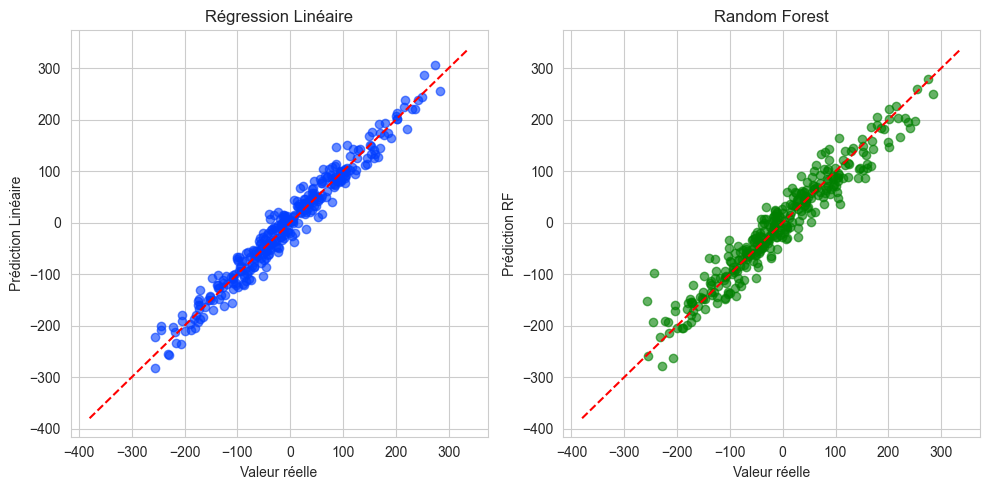

In [35]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(y_val, y_pred_lr, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valeur réelle")
plt.ylabel("Prédiction Linéaire")
plt.title("Régression Linéaire")

plt.subplot(1,2,2)
plt.scatter(y_val, y_pred_rf, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valeur réelle")
plt.ylabel("Prédiction RF")
plt.title("Random Forest")

plt.tight_layout()
plt.show()

# Étape 9 : Prédictions sur le test et sauvegarde

In [36]:
# Meilleur modèle
best_model = rf if r2_score(y_val, y_pred_rf) > r2_score(y_val, y_pred_lr) else lr
best_model.fit(X, y)  # Ré-entraînement sur tout train

predictions = best_model.predict(test)

predicted_test = test.copy()
predicted_test['predicted_target'] = predictions

display(predicted_test.head())

# Sauvegarde sous format csv
predicted_test.to_csv("predicted_test.csv", index=False)
print("Fichier predicted_test.csv sauvegardé !")

,feature_1,feature_2,feature_3,feature_4,feature_5,predicted_target
0,1.015254,2.076209,-0.266435,-2.418088,-0.980503,114.583689
1,-0.375021,0.953185,0.626719,0.704406,-0.355489,118.012815
2,-1.024452,0.962991,-0.407942,-1.861274,0.455201,-21.739852
3,-2.489841,0.544802,0.601219,-0.607021,-1.314286,-43.936899
4,-0.384675,-0.833624,1.358552,-0.547932,0.411925,-95.914898


Fichier predicted_test.csv sauvegardé !


# Étape 10 : Pairplot final

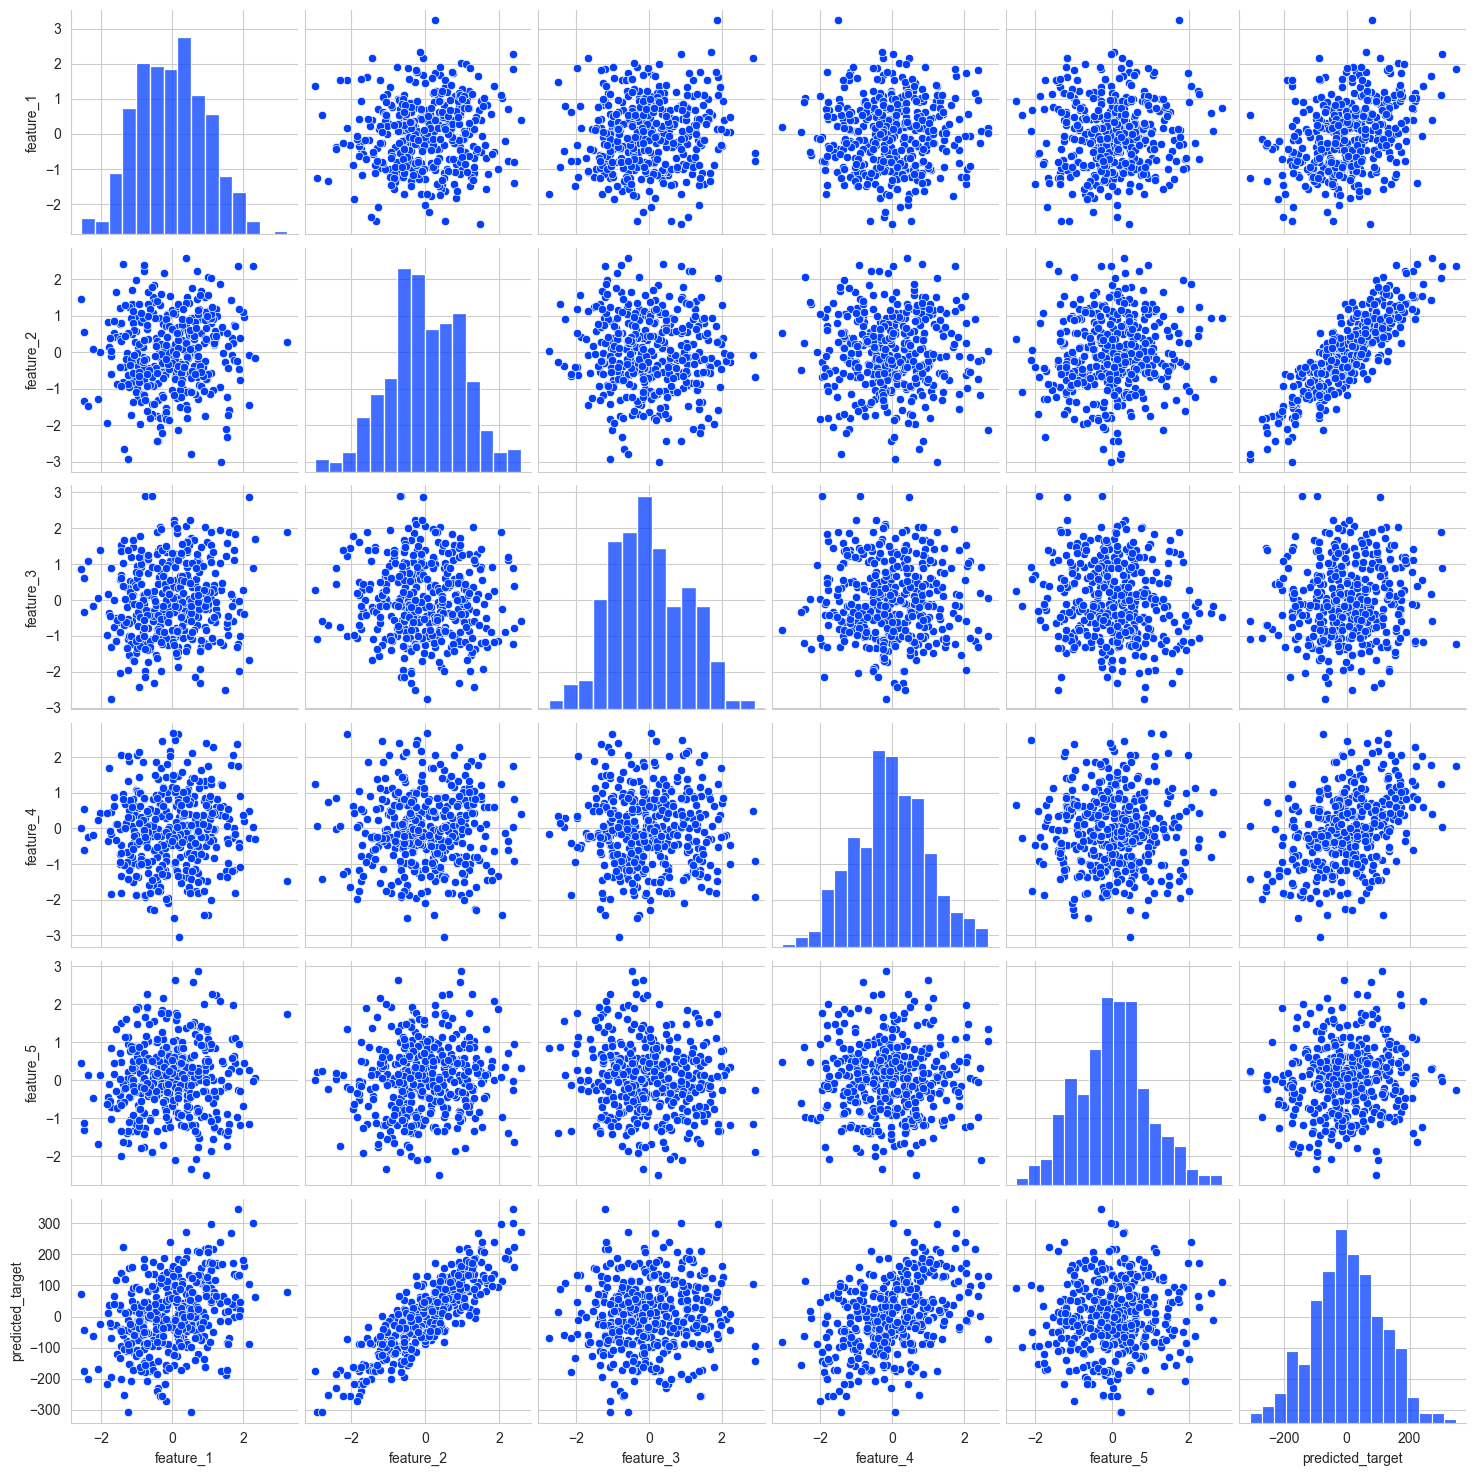

In [37]:
sns.set_palette("bright")
sns.pairplot(predicted_test)
plt.show()

# SHAP : Interprétabilité des modèles de Machine Learning

## Qu’est-ce que SHAP ?
- SHAP = SHapley Additive exPlanations
C’est LA méthode la plus rigoureuse et la plus utilisée en 2025 pour expliquer n’importe quel modèle de Machine Learning (même les boîtes noires comme Random Forest, XGBoost, etc.).

- Pourquoi c’est génial ?
    - Il te dit exactement combien chaque variable (feature_1, feature_2…) a poussé la prédiction vers le haut ou vers le bas pour chaque individu.
    - C’est mathématiquement juste (basé sur la théorie des jeux de Shapley, prix Nobel d’économie !).
    - Ça marche même si ton modèle est non linéaire ou avec interactions.
    - Tu peux expliquer une seule prédiction ou le modèle global.

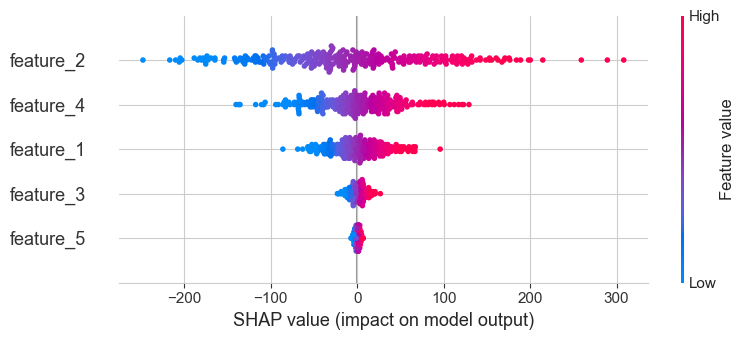

In [39]:
import shap

# Correct pour la régression linéaire
explainer = shap.LinearExplainer(lr, masker=X_train) 

shap_values = explainer.shap_values(X_val)

# Visualisation
shap.summary_plot(shap_values, X_val)